# Load and setup the data and variables

In [1]:
expr_mouse = "../../data/prepared/mouse_scaled.tsv.gz"
expr_human = "../../data/prepared/human_scaled.tsv.gz"
conservation = "../../data/prepared/aucs.tsv.gz"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn import preprocessing, decomposition

In [3]:
aurocs = pd.read_csv(conservation, sep="\t", index_col=0).mean(axis=1)
aurocs.rename('auroc', inplace=True)

SLC39A1    0.521690
SCAMP2     0.247573
LYRM7      0.546687
SYVN1      0.420172
SHC4       0.272679
             ...   
DOCK9      0.258718
PLXNB2     0.272631
RGS8       0.399987
CCNO       0.499295
ACOT7      0.296424
Name: auroc, Length: 11139, dtype: float64

In [4]:
mouse = pd.read_csv(expr_mouse, sep="\t", header=0, index_col=[0,1])
human = pd.read_csv(expr_human, sep="\t", header=0, index_col=[0,1])
mouse.head().iloc[:,:5]

Xkr4     Gm1992    Gm37381        Rp1     Mrpl15
celltype donor_id                                                        
E_1      F003      150.431298  96.168484   5.888929  23.691612  77.763569
         F004      146.923587  88.845963  13.489568  21.113059  83.094336
         F005      155.846667  99.615089  10.187479  25.548710  78.363895
         F006      152.220075  93.619603   7.656298  22.170951  80.374269
         F007      156.802103  96.535744   3.521052  29.365177  78.778955

In [5]:
mouse.shape

(280, 19074)

In [6]:
human.shape

(111, 12383)

We have to capitalize all of the mouse gene names.

In [7]:
mouse.columns = [gene.upper() for gene in mouse.columns]
human.columns = [gene.upper() for gene in human.columns]
mouse.columns

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'MRPL15', 'LYPLA1', 'GM37988',
       'TCEA1', 'RGS20', 'GM16041',
       ...
       'MT-ND5', 'MT-ND6', 'MT-CYTB', 'VAMP7', 'SPRY3', 'TMLHE', 'AC132444.5',
       'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=19074)

We're only interested in genes that are shared between the two species.

In [8]:
genes = list(set(mouse.columns).intersection(human.columns))
len(genes)

11139

In [9]:
mouse_genes = mouse.loc[:,genes]
human_genes = human.loc[:,genes]
human_genes.shape

(111, 11139)

Let's rescale across samples now that we've excluded some genes.

In [10]:
mouse_genes = mouse_genes.divide(mouse_genes.sum(axis=1), axis=0)*1e6
human_genes = human_genes.divide(human_genes.sum(axis=1), axis=0)*1e6
mouse_genes.head().iloc[:,:5]

COPB2        NAPA        FGR     KLHL21     PFKFB1
celltype donor_id                                                         
E_1      F003      113.164104  131.738443  13.713570  55.692387  32.568548
         F004      113.485425  133.861156  14.708317  56.512288  31.145289
         F005      115.183014  134.057250  10.634784  61.063099  27.114001
         F006      112.915882  132.775483   5.776027  56.484902  30.015993
         F007      113.277613  130.150120  12.852184  58.703377  34.607796

# Obtain the mean expression over samples in each celltype

In [11]:
mean_mouse = mouse_genes.groupby('celltype').mean().T
mean_mouse.index.names = ['gene']
mean_human = human_genes.groupby('celltype').mean().T
mean_human.index.names = ['gene']
mean_mouse.head().iloc[:,:5]

celltype,E_1,E_10,E_11,E_12,E_14
gene,,,,,
COPB2,112.096592,100.951157,112.980051,101.683577,102.190283
NAPA,133.773772,129.214507,128.698621,124.327731,125.334387
FGR,12.345369,23.637869,17.040940,14.296527,14.073713
KLHL21,56.352906,44.390933,45.123917,41.942983,46.779722
PFKFB1,32.917424,35.575397,27.467164,34.470755,36.106645


In [12]:
mean_mouse.shape

(11139, 33)

In [13]:
mean_human.shape

(11139, 58)

Let's also merge the data into a single dataframe.

In [14]:
def merge_dfs(expr, aurocs):
    return expr.merge(aurocs, left_index=True, right_index=True)

In [15]:
full_mouse = merge_dfs(mean_mouse, aurocs)
full_human = merge_dfs(mean_human, aurocs)
full_mouse.head().iloc[:,-5:]

,N_4,N_5,N_6,N_7,auroc
COPB2,108.199163,102.141779,127.557901,126.280004,0.260606
NAPA,119.684541,109.457941,126.069278,124.703281,0.471526
FGR,58.522537,12.728392,19.012111,8.792888,0.371501
KLHL21,45.318280,36.894158,45.332520,57.468412,0.481665
PFKFB1,43.300974,34.548991,37.344108,21.976517,0.339596


# Perform a basic regression without correcting for anything

In [16]:
def multiple_reg(expr, full_expr):
    sumstats = {}
    for celltype in expr.columns:
        model = smf.ols(formula=f"{celltype} ~ auroc", data=full_expr)
        res = model.fit()
        sumstats[celltype] = res.summary2().tables[1].loc['auroc']
    sumstats = pd.DataFrame(sumstats).T
    sumstats.index.names = ['celltype']
    sumstats.columns = ['beta', 'stderr', 't', 'pval', 'CI_start', 'CI_end']
    return sumstats

In [17]:
mouse_res = multiple_reg(mean_mouse, full_mouse)
mouse_res.head()

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,82.423015,3.996945,20.621505,9.396040e-93,74.588296,90.257734
E_10,76.551882,3.962917,19.317055,8.349462e-82,68.783863,84.319900
E_11,84.058203,4.146791,20.270662,9.610085e-90,75.929758,92.186647
E_12,73.141438,4.092515,17.872003,1.870087e-70,65.119384,81.163492
E_14,76.397451,3.964780,19.269026,2.051700e-81,68.625780,84.169122


In [18]:
human_res = multiple_reg(mean_human, full_human)
human_res.head()

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,59.726346,4.012363,14.885579,1.225496e-49,51.861404,67.591287
E_10,61.248746,3.837877,15.959015,1.046602e-56,53.725826,68.771665
E_11,59.311525,3.941643,15.047412,1.128753e-50,51.585207,67.037843
E_12,62.654775,4.089091,15.322420,1.854171e-52,54.639432,70.670118
E_13,57.767353,3.907285,14.784526,5.365839e-49,50.108383,65.426323


# Plot the distribution of the expression correlation matrix

In [19]:
def offdiag(corr):
    offdiag_idxs = np.where(~np.eye(corr.shape[0],dtype=bool))
    return corr[offdiag_idxs]

In [20]:
def sample_corr(expr):
    corr = np.corrcoef(expr, expr)[:expr.shape[0], :expr.shape[0]]
    return corr

In [21]:
def plot_corr(expr):
    corr_offdiag = offdiag(sample_corr(expr))
    _, bins, ax = plt.hist(corr_offdiag, bins=1000, density=True)
    plt.plot(bins, norm.pdf(bins, 0, 1/np.sqrt(expr.shape[1]-2)))

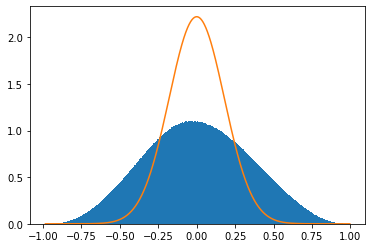

In [22]:
plot_corr(mean_mouse.values)

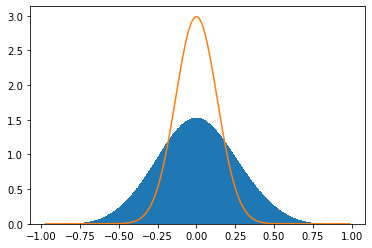

In [23]:
plot_corr(mean_human.values)

# Scale the gene expression values

Seems like there's some correlation. Can we reduce it by scaling the values?

In [24]:
def scale_expr(expr):
    return expr.subtract(expr.mean(axis=1), axis=0).divide(expr.std(axis=1), axis=0)

In [25]:
mouse_scaled = scale_expr(mean_mouse)
human_scaled = scale_expr(mean_human)
mouse_scaled.shape

(11139, 33)

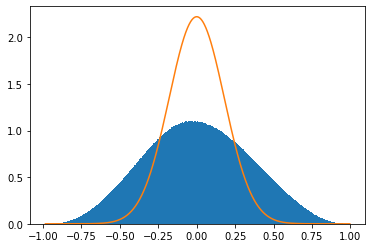

In [26]:
plot_corr(mouse_scaled)

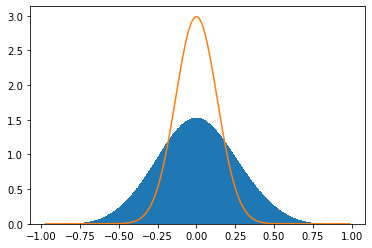

In [27]:
plot_corr(human_scaled)

# Correct for gene correlation by regressing out PCs

Let's first obtain the PCs of each expression matrix.

In [28]:
def get_PCs(expr):
    pca = decomposition.PCA(svd_solver='full')
    pca.fit(expr)
    exp_var = pca.explained_variance_
    plt.scatter(range(len(exp_var)), exp_var)
    return pca

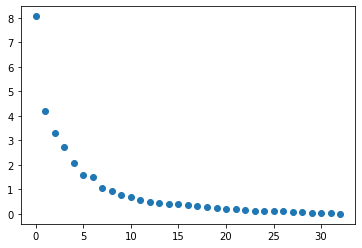

In [29]:
mouse_pca = get_PCs(mouse_scaled)

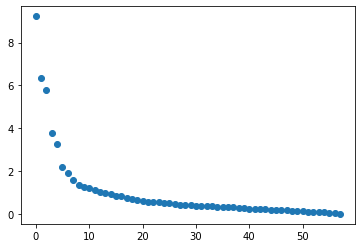

In [30]:
human_pca = get_PCs(human_scaled)

Seems like the first PC captures most of the variance.

In [31]:
def regress_PCs(pca, expr, num_PCs=10):
    transformed = pca.transform(expr)
    transformed[:,num_PCs:] = 0
    pc1_vals = pca.inverse_transform(transformed)
    return expr - pc1_vals

In [32]:
mouse_resid = regress_PCs(mouse_pca, mouse_scaled)
mouse_resid.shape

(11139, 33)

In [33]:
human_resid = regress_PCs(human_pca, human_scaled)
human_resid.shape

(11139, 58)

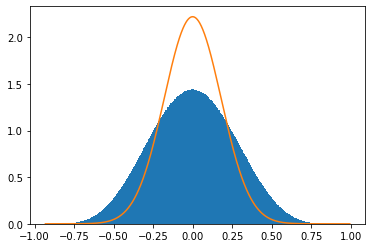

In [34]:
plot_corr(mouse_resid.values)

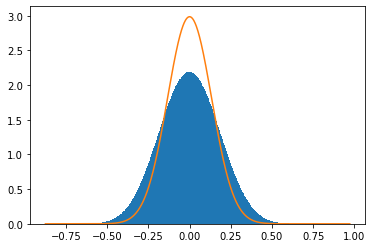

In [35]:
plot_corr(human_resid.values)

# Redo the regression with the residuals

In [47]:
mouse_pca_res = multiple_reg(mouse_resid, merge_dfs(mouse_resid, aurocs))
human_pca_res = multiple_reg(human_resid, merge_dfs(human_resid, aurocs))
mouse_pca_res.head()

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,0.097996,0.033565,2.919596,0.003512,0.032203,0.163789
E_10,0.062802,0.031607,1.986970,0.046950,0.000847,0.124756
E_11,0.069819,0.040222,1.735844,0.082619,-0.009023,0.148661
E_12,-0.031270,0.044447,-0.703538,0.481735,-0.118393,0.055853
E_14,0.007862,0.027963,0.281149,0.778601,-0.046951,0.062675


Subset to just the significant celltypes.

In [48]:
alpha = 0.05

In [49]:
mouse_sig = mouse_pca_res[mouse_pca_res['pval'] < alpha]
human_sig = human_pca_res[human_pca_res['pval'] < alpha]
print(len(mouse_sig), len(human_sig)) # how many significant celltypes are there?

13 20


In [38]:
mouse_sig

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,0.097996,0.033565,2.919596,0.003512,0.032203,0.163789
E_10,0.062802,0.031607,1.986970,0.046950,0.000847,0.124756
E_22,-0.082435,0.039141,-2.106113,0.035217,-0.159158,-0.005712
E_3,-0.107466,0.025199,-4.264663,0.000020,-0.156860,-0.058071
E_5,0.109627,0.031046,3.531142,0.000415,0.048772,0.170482
I_1,-0.119811,0.048954,-2.447414,0.014404,-0.215770,-0.023852
I_10,-0.094047,0.040749,-2.307942,0.021021,-0.173923,-0.014171
I_12,0.080583,0.027023,2.982034,0.002870,0.027613,0.133552
I_21,0.088139,0.030956,2.847276,0.004418,0.027461,0.148818


In [39]:
human_sig

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,0.100499,0.038403,2.616949,8.883946e-03,0.025222,0.175776
E_10,-0.141452,0.036212,-3.906187,9.431783e-05,-0.212435,-0.070470
E_12,0.122665,0.055225,2.221176,2.635908e-02,0.014414,0.230917
E_15,-0.077324,0.037105,-2.083933,3.718901e-02,-0.150057,-0.004592
E_18,-0.098251,0.044596,-2.203124,2.760644e-02,-0.185668,-0.010835
E_2,-0.249438,0.052259,-4.773131,1.836909e-06,-0.351874,-0.147001
E_20,0.271002,0.041139,6.587469,4.675531e-11,0.190362,0.351642
E_22,0.134200,0.052697,2.546641,1.088986e-02,0.030905,0.237495
E_5,-0.079090,0.029611,-2.671005,7.573449e-03,-0.137132,-0.021048


Which of the significant celltypes are shared between species?

In [40]:
set(mouse_sig.index).intersection(human_sig.index)

{'E_1', 'E_10', 'E_22', 'E_5', 'I_21', 'I_3', 'I_4'}

# Correct for multiple hypothesis testing
Let's perform an FDR correction.

First, let's plot the distribution of the t-statistics.

<AxesSubplot:>

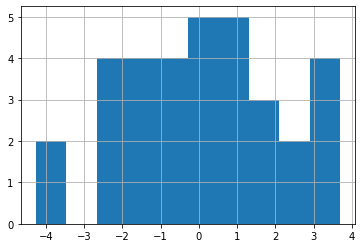

In [52]:
mouse_pca_res['t'].hist(bins=5)

<AxesSubplot:>

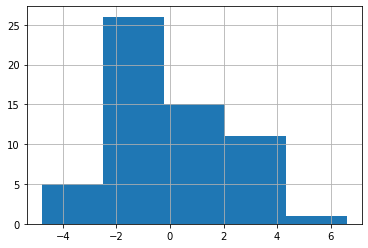

In [53]:
human_pca_res['t'].hist(bins=5)